In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.optimize import curve_fit
from qubit import ColorCenterQubit

ModuleNotFoundError: No module named 'qutip'

# Scheme 3 Analysis: Optical down + Excited and Ground MW

## Microwave Power Balance Tuning
In order to directly initialize to a superposition of 1/2 spin up and down, we run a binary search on a range of ground microwave powers given the "known" excited microwave transition power.

In [4]:
target_spin_down = 0.5
optical_amp = 1
mw_excited_amp = 0.1
mw_ground_amp_step = 0.3
mw_ground_amp = max(mw_excited_amp - mw_ground_amp_step/2, 0)
step_parity = 1
num_steps = 12

# Use a binary search to find the correct microwave amplitude
tin_center = ColorCenterQubit()
# print(f"Initial Spin State: Up: {np.cos(tin_center.initial_spin_angle)**2*100:0.2f}%, Down: {np.sin(tin_center.initial_spin_angle)**2*100:0.2f}%")
t, spin_down, spin_up, post_initialization_states = tin_center.apply_pulse(optical_amp, 0, mw_excited_amp, mw_ground_amp)
print(f"Up: {spin_up[-1]*100:0.2f}%, Down: {spin_down[-1]*100:0.2f}%")
last_spin_down = spin_down[-1]
for i in range(num_steps):
    tin_center = ColorCenterQubit()
    mw_ground_amp += step_parity*mw_ground_amp_step
    t, spin_down, spin_up, post_initialization_states = tin_center.apply_pulse(optical_amp, 0, mw_excited_amp, mw_ground_amp)
    current_spin_down = spin_down[-1]
    if (current_spin_down - target_spin_down)*(last_spin_down - target_spin_down) < 0:
        step_parity *= -1
    mw_ground_amp_step /= 2
    last_spin_down = current_spin_down
    print(f"Up: {spin_up[-1]*100:0.3f}%, Down: {spin_down[-1]*100:0.3f}%")
print(f"Final Pulse Parameters: Optical: {optical_amp}, Microwave Excited: {mw_excited_amp}, Microwave Ground: {mw_ground_amp}")


Up: 91.82%, Down: 8.18%
Up: 39.835%, Down: 60.165%
Up: 60.080%, Down: 39.920%
Up: 46.920%, Down: 53.080%
Up: 52.528%, Down: 47.472%
Up: 49.506%, Down: 50.494%
Up: 50.959%, Down: 49.041%
Up: 50.218%, Down: 49.782%
Up: 49.859%, Down: 50.141%
Up: 50.038%, Down: 49.962%
Up: 49.948%, Down: 50.052%
Up: 49.993%, Down: 50.007%
Up: 50.015%, Down: 49.985%
Final Pulse Parameters: Optical: 1, Microwave Excited: 0.1, Microwave Ground: 0.20288085937499997


## Performance of initialization scheme over all initial states
Explore the performance of this initialization scheme over all starting superposition angles. Also, find the approximate settling time versus starting angle.

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


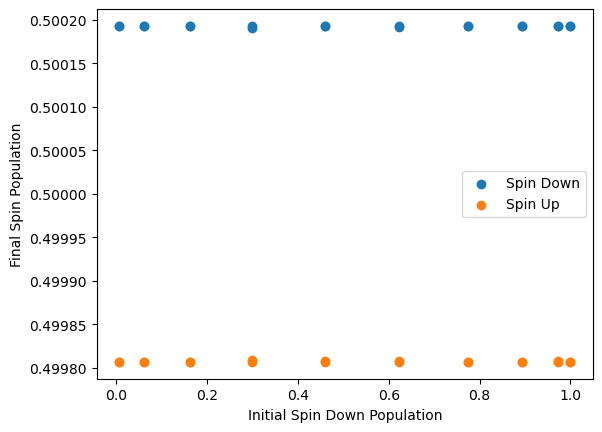

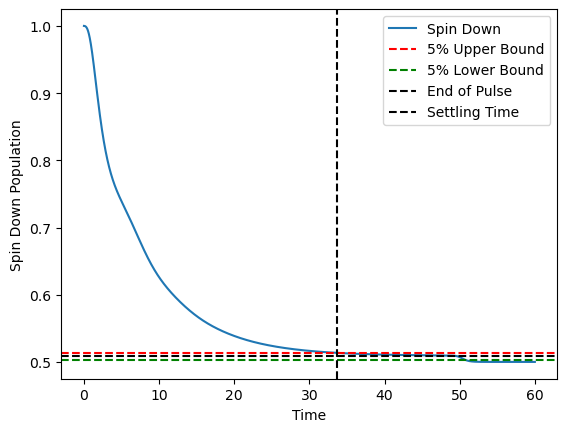

ValueError: x and y must be the same size

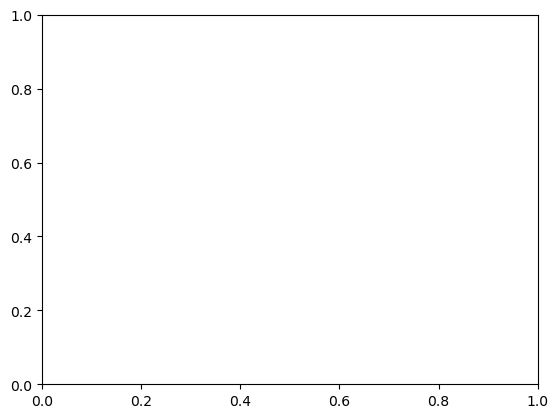

In [7]:
# Test the initialization sequence with n sweeping initial angles
n = 20
init_length = 50
max_time = init_length + 10
time_res = 200
num_t = int(max_time*time_res)+1
init_start = 0
optical_ramp_time = 0.3
mw_ramp_time = 0.3

spin_downs = np.zeros((n, num_t))
spin_ups = np.zeros((n, num_t))
initial_spin_angle = np.array([np.linspace(0, np.pi, n), 2*np.pi*np.random.rand(n)])
for i in tqdm(range(n)):
    tin_center = ColorCenterQubit(initial_spin_angle[:, i], optical_ramp_time=optical_ramp_time, mw_ramp_time=mw_ramp_time)
    t, spin_down, spin_up, post_initialization_states = tin_center.apply_pulse(optical_amp, 0, mw_excited_amp, mw_ground_amp, pulse_length=init_length, pulse_start=init_start, max_time=max_time, time_res=time_res)
    spin_downs[i] = spin_down
    spin_ups[i] = spin_up

# Scatterplot the final spin down and up populations vs initial angle
plt.figure()
plt.scatter(np.cos(initial_spin_angle[0,:])**2, spin_downs[:, -1], label='Spin Down')
plt.scatter(np.cos(initial_spin_angle[0,:])**2, spin_ups[:, -1], label='Spin Up')
plt.xlabel("Initial Spin Down Population")
plt.ylabel("Final Spin Population")
plt.ticklabel_format(axis='y', useOffset=False)
plt.legend()
plt.show()


# Find the index of the time a second before the initial pulse ends
pulse_end_id = np.argmin(np.abs(t - init_length + optical_ramp_time + init_start))
pulse_end_down_population = spin_downs[:, pulse_end_id]

# Determine the settling time by considering the time it takes for the spin down to be within 5% of the value at the end of the pulse. Because it might oscillate around this value, we take the last time it reaches this value.
trimmed_spin_downs = spin_downs[:, :pulse_end_id]
settling_time = np.zeros(n)
settling_threshold = 0.01

for i in range(n):
    upper_bound = pulse_end_down_population[i] + settling_threshold*pulse_end_down_population[i]
    lower_bound = pulse_end_down_population[i] - settling_threshold*pulse_end_down_population[i]
    low_i = 0
    high_i = pulse_end_id
    while low_i < high_i:
        mid = (low_i + high_i) // 2
        if np.all((trimmed_spin_downs[i, mid:] < upper_bound) & (trimmed_spin_downs[i, mid:] > lower_bound)):
            settling_time[i] = t[mid]
            high_i = mid-1
        else:
            low_i = mid+1
    # Plot the settling time with lower and upper bounds on the spin down population
    if i == 0:
        plt.figure()
        plt.plot(t, spin_downs[i], label='Spin Down')
        plt.axhline(y=upper_bound, color='r', linestyle='--', label='5% Upper Bound')
        plt.axhline(y=lower_bound, color='g', linestyle='--', label='5% Lower Bound')
        plt.axhline(y=pulse_end_down_population[i], color='k', linestyle='--', label='End of Pulse')
        plt.axvline(x=settling_time[i], color='k', linestyle='--', label='Settling Time')
        plt.xlabel("Time")
        plt.ylabel("Spin Down Population")
        plt.legend()
        plt.show()


# Scatterplot the settling time vs initial angle
plt.figure()
plt.scatter(np.cos(initial_spin_angle)**2, settling_time)
plt.title("Settling Time of initialization scheme vs Initial Spin Down population")
plt.xlabel("Initial Spin Down Population")
plt.ylabel("Settling Time")
plt.ticklabel_format(axis='y', useOffset=False)
plt.show()





## Test the robustness of this scheme to optical power changes
This should not be an issue as long as the optical power is always pumped to saturation

100%|██████████| 25/25 [00:51<00:00,  2.06s/it]


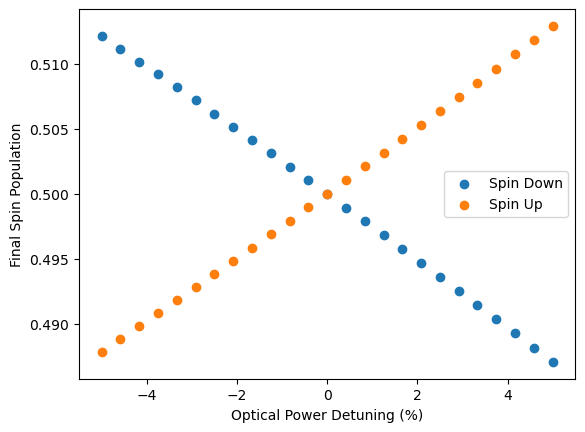

In [ ]:
# Test the initialization sequence with n trials sweeping the optical power over +-5%
n = 25
init_length = 60.3
max_time = init_length + 10
time_res = 200
num_t = int(max_time*time_res)+1
init_start = 0
optical_ramp_time = 0.3
mw_ramp_time = 0.3

spin_downs = np.zeros((n, num_t))
spin_ups = np.zeros((n, num_t))
detuning = 0.05*np.linspace(-1.0,1.0, n)
optical_power_detuning = detuning*optical_amp
for i in tqdm(range(n)):
    tin_center = ColorCenterQubit(optical_ramp_time=optical_ramp_time, mw_ramp_time=mw_ramp_time)
    t, spin_down, spin_up, post_initialization_states = tin_center.apply_pulse(optical_amp+optical_power_detuning[i], 0, mw_excited_amp, mw_ground_amp, pulse_length=init_length, pulse_start=init_start, max_time=max_time, time_res=time_res)
    spin_downs[i] = spin_down
    spin_ups[i] = spin_up

# Scatterplot the final spin down and up populations vs initial angle
plt.figure()
plt.scatter(detuning*100, spin_downs[:, -1], label='Spin Down')
plt.scatter(detuning*100, spin_ups[:, -1], label='Spin Up')
plt.xlabel("Optical Power Detuning (%)")
plt.ylabel("Final Spin Population")
plt.ticklabel_format(axis='y', useOffset=False)
plt.legend()
plt.show()


## Test Microwave Power Robustness
Determine the error in the state initialization with respect to changes in the microwave power. Not that the FPGA should hold the relative power of the 2 microwave frequencies constant, so the detuning applies to both at once.

100%|██████████| 25/25 [00:44<00:00,  1.79s/it]


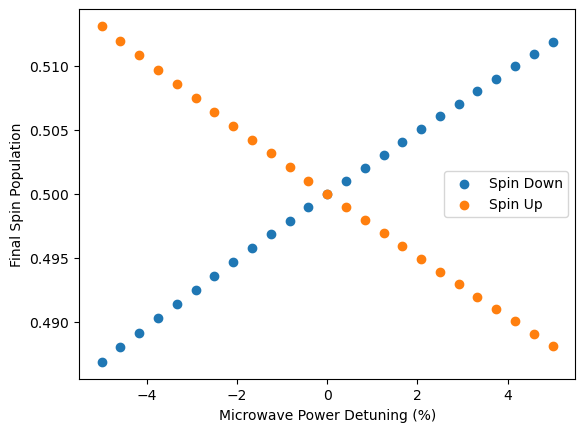

In [ ]:
# Test the initialization sequence with n trials sweeping the microwave power over +-5%
n = 25
init_length = 60.3
max_time = init_length + 10
time_res = 200
num_t = int(max_time*time_res)+1
init_start = 0
optical_ramp_time = 0.3
mw_ramp_time = 0.3

spin_downs = np.zeros((n, num_t))
spin_ups = np.zeros((n, num_t))
detuning = 0.05*np.linspace(-1.0,1.0, n)
mw_excited_power_detuning = detuning*mw_excited_amp
mw_ground_power_detuning = detuning*mw_ground_amp
for i in tqdm(range(n)):
    tin_center = ColorCenterQubit(optical_ramp_time=optical_ramp_time, mw_ramp_time=mw_ramp_time)
    t, spin_down, spin_up, post_initialization_states = tin_center.apply_pulse(optical_amp, 0, mw_excited_amp+mw_excited_power_detuning[i], mw_ground_amp+mw_ground_power_detuning[i], pulse_length=init_length, pulse_start=init_start, max_time=max_time, time_res=time_res)
    spin_downs[i] = spin_down
    spin_ups[i] = spin_up

# Scatterplot the final spin down and up populations vs initial angle
plt.figure()
plt.scatter(detuning*100, spin_downs[:, -1], label='Spin Down')
plt.scatter(detuning*100, spin_ups[:, -1], label='Spin Up')
plt.xlabel("Microwave Power Detuning (%)")
plt.ylabel("Final Spin Population")
plt.ticklabel_format(axis='y', useOffset=False)
plt.legend()
plt.show()


# Compare Initialization Schemes
3 initialization schemes are presented here:  
1. Optical_down only - this scheme uses only optical pumping on spin down to initialize the state to spin up
2. Optical_down + Excited MW - this scheme pumps on the ground_down->excited_down transition but also on the excited_down-excited_up transition for a slightly faster initialization to spin up
3. Optical_down + Excited and Ground MW - this scheme pumps on the ground_down->excited_down transition but also on the excited_down-excited_up transition and the ground_down-ground_up transition to initialize straight to a 50-50 superposition of spin up and spin down
4. (Untested) Optical_down + Optical_up + Excited MW + Ground MW - This scheme could work, but is untested

In [42]:
def get_ground_bloch_angles(state):
    """Return (theta, phi) for the ground-manifold qubit in the final state."""
    # 1) Convert to density matrix if needed
    if state.isket:
        rho_full = ket2dm(state)
    else:
        rho_full = state
    
    # 2) Partial trace out the two photonic modes => spin only
    rho_spin_4x4 = ptrace(rho_full, [2])
    
    # 3) Project onto ground manifold (|g↓>, |g↑>) and renormalize
    P_gd = basis(4, 0) * basis(4, 0).dag()
    P_gu = basis(4, 1) * basis(4, 1).dag()
    P_ground = P_gd + P_gu
    
    rho_g = P_ground * rho_spin_4x4 * P_ground
    p_g = rho_g.tr()
    if p_g > 0:
        rho_g = rho_g / p_g
    
    # 4) Convert that 4x4 block to a 2x2 Qobj
    r00 = rho_g[0,0]
    r01 = rho_g[0,1]
    r10 = rho_g[1,0]
    r11 = rho_g[1,1]
    rho_qubit = Qobj([[r00, r01],
                      [r10, r11]],
                     dims=[[2],[2]])
    
    # 5) Expectation values
    x_val = expect(sigmax(), rho_qubit)
    y_val = expect(sigmay(), rho_qubit)
    z_val = expect(sigmaz(), rho_qubit)
    
    # Bloch angles
    theta = np.arccos(z_val)
    phi = np.arctan2(y_val, x_val)
    return theta, phi

Overlap: (0.996308394360527+0j)


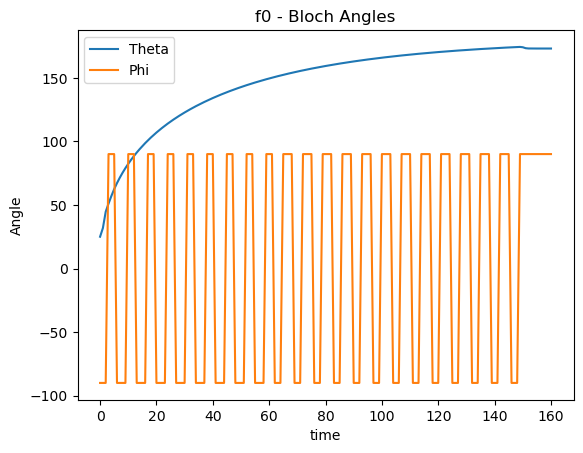

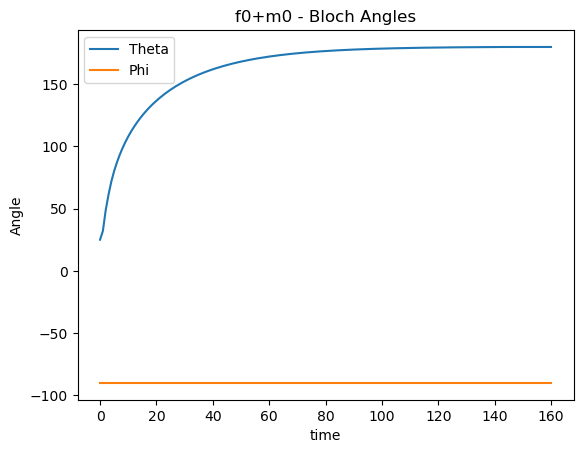

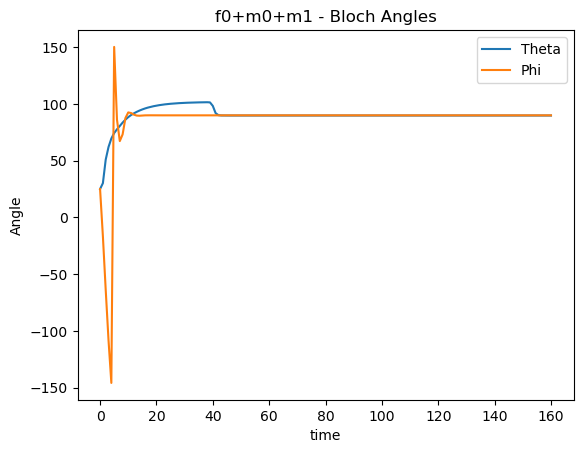

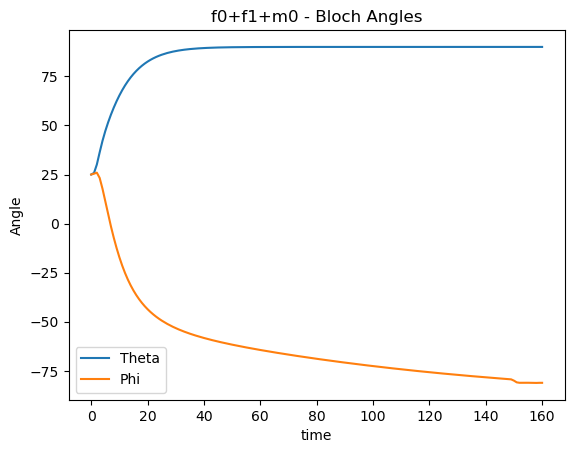

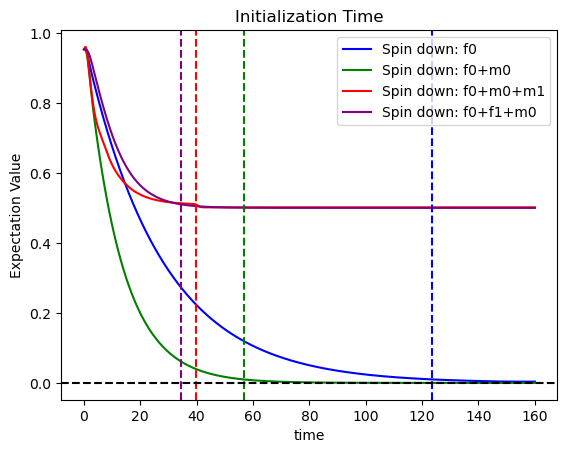

f0: 123.62
f0+m0: 56.63
f0+m0+m1: 39.70
f0+f1+m0: 34.54


In [40]:
max_mw_power = mw_ground_amp + mw_excited_amp
average_mw_power = (mw_ground_amp + mw_excited_amp)/2

# Scheme 1:Plot the performance of pumping only optically down
tin_center = ColorCenterQubit([25, -90])
t, spin_down_op, spin_up_op, post_initialization_states = tin_center.apply_pulse(1, 0, 0, 0, 150, max_time=160)
print(f"Overlap: {tin_center.gu.overlap(post_initialization_states[-1])}")

init_theta, init_phi = get_ground_bloch_angles(tensor(*tuple([tin_center.photon_t0]*tin_center.cavity_modes+[tin_center.initial_spin_state])))

binning=200
theta = []
phi = []
for state in post_initialization_states[::binning]:
    th, p = get_ground_bloch_angles(state)
    theta.append(np.degrees(th))
    phi.append(np.degrees(p))

plt.figure()
plt.plot(t[::binning], theta, label='Theta')
plt.plot(t[::binning], phi, label='Phi')
plt.title("f0 - Bloch Angles")
plt.xlabel("time")
plt.ylabel("Angle")
plt.legend()
plt.show()


# Locate the first time spin down reaches 0.01
spin_down_threshold = 0.01
spin_down_threshold_id_op = np.argmax(spin_down_op < spin_down_threshold)

# Scheme 2: Plot the performance of pumping optically with the excited mw transition
tin_center = ColorCenterQubit([25, -90])
t, spin_down_op_emw, spin_up_op_emw, post_initialization_states_op_emw = tin_center.apply_pulse(optical_amp, 0, max_mw_power, 0, 150, max_time=160)
# Locate the first time spin down reaches 0.01
spin_down_threshold_id_op_emw = np.argmax(spin_down_op_emw < spin_down_threshold)

theta = []
phi = []
for state in post_initialization_states_op_emw[::binning]:
    th, p = get_ground_bloch_angles(state)
    theta.append(np.degrees(th))
    phi.append(np.degrees(p))

plt.figure()
plt.plot(t[::binning], theta, label='Theta')
plt.plot(t[::binning], phi, label='Phi')
plt.title("f0+m0 - Bloch Angles")
plt.xlabel("time")
plt.ylabel("Angle")
plt.legend()
plt.show()

# Scheme 3: Plot the performance of pumping optically with the balance of excited and ground mw transitions
tin_center = ColorCenterQubit([25, 25])
t, spin_down_op_mw, spin_up_op_mw, post_initialization_states = tin_center.apply_pulse(optical_amp, 0, mw_excited_amp, mw_ground_amp, 40, max_time=160)
# Locate the first time spin down reaches 0.51
spin_down_threshold = 0.51
spin_down_threshold_id_op_mw = np.argmax(spin_down_op_mw < spin_down_threshold)

theta = []
phi = []
for state in post_initialization_states[::binning]:
    th, p = get_ground_bloch_angles(state)
    theta.append(np.degrees(th))
    phi.append(np.degrees(p))

plt.figure()
plt.plot(t[::binning], theta, label='Theta')
plt.plot(t[::binning], phi, label='Phi')
plt.title("f0+m0+m1 - Bloch Angles")
plt.xlabel("time")
plt.ylabel("Angle")
plt.legend()
plt.show()

# Scheme 4: Plot the performance of pumping both optical spin preserving transitions with a ground mw pulse
tin_center = ColorCenterQubit([25, 25])
t, spin_down_allop_mw, spin_up_allop_mw, post_initialization_states = tin_center.apply_pulse(optical_amp/2, optical_amp/2, max_mw_power, 0, 150, max_time=160)
# Locate the first time spin down reaches 0.51
spin_down_threshold = 0.51
spin_down_threshold_id_allop_mw = np.argmax(spin_down_allop_mw < spin_down_threshold)


theta = []
phi = []
for state in post_initialization_states[::binning]:
    th, p = get_ground_bloch_angles(state)
    theta.append(np.degrees(th))
    phi.append(np.degrees(p))

plt.figure()
plt.plot(t[::binning], theta, label='Theta')
plt.plot(t[::binning], phi, label='Phi')
plt.title("f0+f1+m0 - Bloch Angles")
plt.xlabel("time")
plt.ylabel("Angle")
plt.legend()
plt.show()




plt.figure()
plt.plot(t, spin_down_op, color='blue', label='Spin down: f0')
plt.plot(t, spin_down_op_emw, color='g', label='Spin down: f0+m0')
plt.plot(t, spin_down_op_mw, color='red', label='Spin down: f0+m0+m1')
plt.plot(t, spin_down_allop_mw, color='purple', label='Spin down: f0+f1+m0')
plt.axvline(x=t[spin_down_threshold_id_op], color='blue', linestyle='--')
plt.axvline(x=t[spin_down_threshold_id_op_emw], color='g', linestyle='--')
plt.axvline(x=t[spin_down_threshold_id_op_mw], color='red', linestyle='--')
plt.axvline(x=t[spin_down_threshold_id_allop_mw], color='purple', linestyle='--')
# Horizontal line at 0
plt.axhline(y=0, color='k', linestyle='--')
plt.title("Initialization Time")
plt.xlabel("time")
plt.ylabel("Expectation Value")
plt.legend()
plt.show()

print(f"f0: {t[spin_down_threshold_id_op]:.2f}")
print(f"f0+m0: {t[spin_down_threshold_id_op_emw]:.2f}")
print(f"f0+m0+m1: {t[spin_down_threshold_id_op_mw]:.2f}")
print(f"f0+f1+m0: {t[spin_down_threshold_id_allop_mw]:.2f}")

In [41]:
max_mw_power = 2 # About 1 us pi pulse

mw_factor=.5
average_mw_power = (mw_ground_amp + mw_excited_amp)/2
# Scheme 4: Plot the performance of pumping both optical spin preserving transitions with a ground mw pulse
tin_center = ColorCenterQubit([25, 25])
t, spin_down_allop_mw, spin_up_allop_mw, post_initialization_states = tin_center.apply_pulse(optical_amp/2, optical_amp/2, max_mw_power*mw_factor*1j, 0, 300, max_time=320)
# Locate the first time spin down reaches 0.51
spin_down_threshold = 0.51
spin_down_threshold_id_allop_mw = np.argmax(spin_down_allop_mw < spin_down_threshold)
binning = 200

theta = []
phi = []
for state in post_initialization_states[::binning]:
    th, p = get_ground_bloch_angles(state)
    theta.append(np.degrees(th))
    phi.append(np.degrees(p))

plt.figure()
plt.plot(t[::binning], theta, label='Theta')
plt.plot(t[::binning], phi, label='Phi')
plt.title("f0+f1+m0 - Bloch Angles")
plt.xlabel("time (us)")
plt.ylabel("Angle")
plt.legend()
plt.show()




plt.figure()
plt.plot(t, spin_down_allop_mw, color='purple', label='Spin down: f0+f1+m0')
plt.axvline(x=t[spin_down_threshold_id_allop_mw], color='purple', linestyle='--')
# Horizontal line at 0
plt.axhline(y=0, color='k', linestyle='--')
plt.title("Initialization Time")
plt.xlabel("time")
plt.ylabel("Expectation Value")
plt.legend()
plt.show()

print(f"f0+f1+m0: {t[spin_down_threshold_id_allop_mw]:.2f}")

TypeError: ufunc 'arctan2' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Initial Pulse Parameters: Optical: 1, Microwave Excited: 0.1, Microwave Ground: 0.20298099517822263


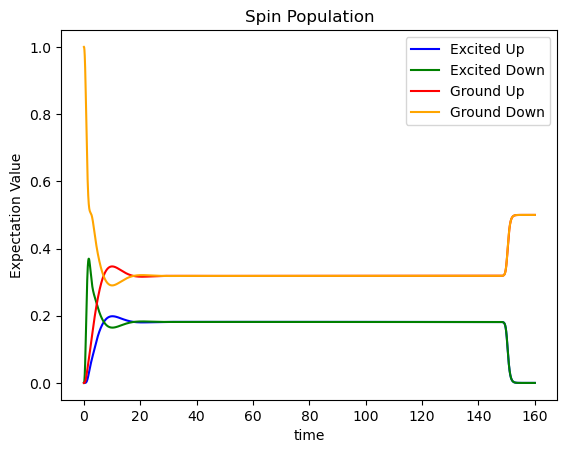

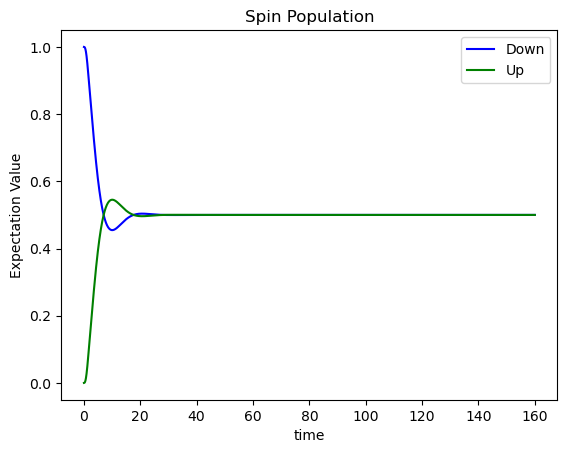

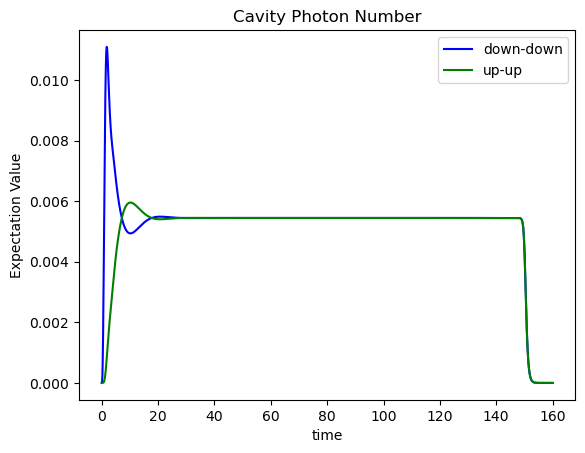

Final Spin Down: 0.500


In [ ]:
# Plot the performance of pumping only optically on both transitions at the same time
tin_center = ColorCenterQubit()
print(f"Initial Pulse Parameters: Optical: {optical_amp}, Microwave Excited: {mw_excited_amp}, Microwave Ground: {mw_ground_amp}")
t, spin_down_op, spin_up_op, post_initialization_states = tin_center.apply_pulse(optical_amp, optical_amp, mw_excited_amp, mw_ground_amp, 150, max_time=160)
# Plot the individual components excited up, excited down, ground up, ground down
spin_down_op_excited_up = expect(tin_center.eu, post_initialization_states)
spin_down_op_excited_down = expect(tin_center.ed, post_initialization_states)
spin_down_op_ground_up = expect(tin_center.gu, post_initialization_states)
spin_down_op_ground_down = expect(tin_center.gd, post_initialization_states)


plt.figure()
plt.plot(t, spin_down_op_excited_up, color='blue', label='Excited Up')
plt.plot(t, spin_down_op_excited_down, color='g', label='Excited Down')
plt.plot(t, spin_down_op_ground_up, color='red', label='Ground Up')
plt.plot(t, spin_down_op_ground_down, color='orange', label='Ground Down')
plt.title("Spin Population")
plt.xlabel("time")
plt.ylabel("Expectation Value")
plt.legend()
plt.show()

# Plot total up and down populations
plt.figure()
plt.plot(t, spin_down_op, color='blue', label='Down')
plt.plot(t, spin_up_op, color='g', label='Up')
plt.title("Spin Population")
plt.xlabel("time")
plt.ylabel("Expectation Value")
plt.legend()
plt.show()


# Plot the cavity photon number
N0 = expect(tin_center.N0, post_initialization_states)
N1 = expect(tin_center.N1, post_initialization_states)
plt.figure()
plt.plot(t, N0, color='blue', label='down-down')
plt.plot(t, N1, color='g', label='up-up')
plt.title("Cavity Photon Number")
plt.xlabel("time")
plt.ylabel("Expectation Value")
plt.legend()
plt.show()

print(f"Final Spin Down: {spin_down_op[-1]:.3f}")

# Valid simulation parameters:

### 01/10/2025
System parameters: cavity_decay_rate=0.1, detection_rate=20.0, atomic_decay_rate=1.0, decoherence_rate=0.1, optical_ramp_time=0.3, mw_ramp_time = 0.3, g0=2.0
Final Pulse Parameters: Optical: 1, Microwave Excited: 0.25, Microwave Ground: 0.28009395599365244, pulse length: 25-60

Initial Spin State: Up: 15.59%, Down: 84.41%
Up: 81.92%, Down: 18.08%
Up: 41.658%, Down: 58.342%
Up: 53.299%, Down: 46.701%
Up: 46.118%, Down: 53.882%
Up: 49.281%, Down: 50.719%
Up: 51.170%, Down: 48.830%
Up: 50.197%, Down: 49.803%
Up: 49.732%, Down: 50.268%
Up: 49.963%, Down: 50.037%
Up: 50.079%, Down: 49.921%
Up: 50.021%, Down: 49.979%
Up: 49.992%, Down: 50.008%
Up: 50.006%, Down: 49.994%
Up: 49.999%, Down: 50.001%
Up: 50.003%, Down: 49.997%
Up: 50.001%, Down: 49.999%
Up: 50.000%, Down: 50.000%
Up: 50.000%, Down: 50.000%
Up: 50.000%, Down: 50.000%
Up: 50.000%, Down: 50.000%
Up: 50.000%, Down: 50.000%
Final Pulse Parameters: Optical: 1, Microwave Excited: 0.25, Microwave Ground: 0.28009395599365244


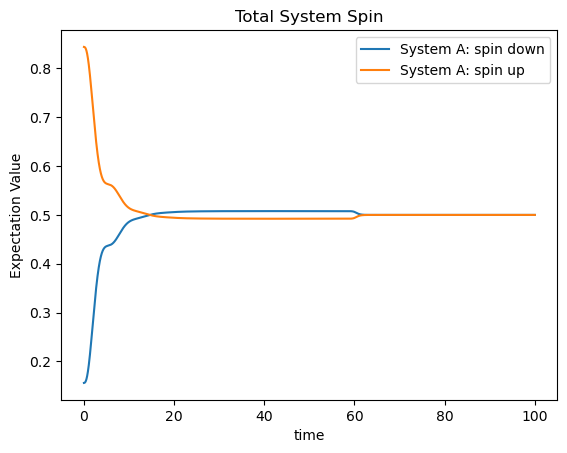

In [ ]:
######################################### Legacy Code ########################################################
# Environment parameters
Na = 4 # number of atomic levels
cavity_modes = 2 # How many frequencies of photons will interact with the cavity mode
N = 2 # Set where to truncate Fock state of cavity

# System parameters
kappa = 0.1 # Cavity decay rate
K_c = 20 # rate for collapsing to detector
gamma=1 # Atomic decay rate
decoherence_rate = 0.1 # spin flipping decoherence strength

ground_down = basis(Na, 0)
ground_up = basis(Na, 1)
excited_down = basis(Na, 2)
excited_up = basis(Na, 3)

system_ids = {"A":0}
basis_ids = {"spin":cavity_modes}
for i in range(cavity_modes):
    basis_ids[f"f{i}"] = i
inv_basis_ids = {v:k for k,v in basis_ids.items()}

# Here, let's choose the basis of state as |photon_A[f0,f1,f2,f3], spin_A, photon_B[f0,f1,f2,f3], spin_B>
def single_operator(system, basis, operator):
    """Helper function to define generic operators on a single basis"""
    transition_list = []
    found = False
    for sys in system_ids:
        for i in range(cavity_modes):
            # Decide whether to place identity or the user provided operator
            if sys == system and i == basis_ids[basis]:
                transition_list.append(operator)
                found = True
            else:
                transition_list.append(qeye(N))

        if sys == system and basis == "spin":
            transition_list.append(operator)
            found = True
        else:
            transition_list.append(qeye(Na))
    if not found:
        raise Exception("Invalid transition requested")
    return tensor(*transition_list)
        

# Spin preserving optical transition
sigma_gd_ed = single_operator("A", "spin", ground_down * excited_down.dag())
sigma_gu_eu = single_operator("A", "spin", ground_up * excited_up.dag())

# Spin flipping optical transition
sigma_gd_eu = single_operator("A", "spin", ground_down * excited_up.dag())
sigma_gu_ed = single_operator("A", "spin", ground_up * excited_down.dag())

# Spin flipping microwave transitions
sigma_gd_gu = single_operator("A", "spin", ground_down * ground_up.dag())
sigma_ed_eu = single_operator("A", "spin", excited_down * excited_up.dag())

# Photon annihilation
a = {}
for i in range(cavity_modes):
    a[inv_basis_ids[i]] = single_operator("A", inv_basis_ids[i], destroy(N))

# Measurement operators
gd_A = single_operator('A', 'spin', ground_down*ground_down.dag())
gu_A = single_operator('A', 'spin', ground_up*ground_up.dag())
ed_A = single_operator('A', 'spin', excited_down*excited_down.dag())
eu_A = single_operator('A', 'spin', excited_up*excited_up.dag())
# N0_A = single_operator('A', 'f0', create(N)*destroy(N))
# N1_A = single_operator('A', 'f1', create(N)*destroy(N))


def initialization_sequence(initial_spin_state=ground_down, optical_amplitude = 1, mw_excited_amplitude = 0.25, mw_ground_amplitude = 0.35, init_length = 60, time_res=200, max_time = 100, init_start = 0, optical_ramp_time = 0.3, mw_ramp_time = 0.3):
    t = np.linspace(0.0, max_time, int(max_time*time_res)+1)
    ################################################ Collapse Operators ########################################################
    c_ops = [] # Build collapse operators

    for i in range(cavity_modes):
        c_ops.append((np.sqrt(kappa)+np.sqrt(K_c)) * (a[inv_basis_ids[i]])) # Cavity decay of system A. C0

    c_ops.append(np.sqrt(gamma) * (sigma_gd_ed + sigma_gu_eu)) # spin preserving spontaneous decay (decaying to modes other than cavity) of system A.   C2
    c_ops.append(np.sqrt(gamma*decoherence_rate) * (sigma_gd_eu + sigma_gu_ed)) # spin flipping spontaneous decay (decaying to modes other than cavity) of system A.   C2


    ########################################################### Spin initialization ###################################################################
    # Pump both systems into ground down
    photon_t0 = basis(N, 0) # Initial photonic state

    initial_state = [photon_t0]*cavity_modes + [initial_spin_state]
    random_spin_state = tensor(*initial_state)

    g0 = 2 # coupling strength (Rabi frequency of vacuum field)

    ########################################################### Time Independent Hamiltonian ###########################################################
    H_A_f0 = -g0 * (sigma_gd_ed.dag()*a['f0'] + a['f0'].dag()*sigma_gd_ed) # Time independent hamiltonian for the down-down transition of cavity
    H_A_f1 = -g0 * (sigma_gu_eu.dag()*a['f1'] + a['f1'].dag()*sigma_gu_eu) # Time independent hamiltonian for the up-up transition of cavity
    # H_A_f2 = -g0*decoherence_rate*(sigma_gd_eu.dag()*a['f2'] + a['f2'].dag()*sigma_gd_eu) # Time independent hamiltonian for the down-up transition of cavity
    # H_A_f3 = -g0*decoherence_rate*(sigma_gd_eu.dag()*a['f3'] + a['f3'].dag()*sigma_gd_eu) # Time independent hamiltonian for the up-down transition of cavity
    H_t_ind = H_A_f0 + H_A_f1 #+ H_A_f2 + H_A_f3 # time-independent Hermitian of global system

    ########################################################### Time Dependent Hamiltonian #############################################################

    def smooth_square_pulse(t, start, width, t_ramp, amplitude):
        ramp_up = 1 / (1 + np.exp(-(t - start) / t_ramp))
        ramp_down = 1 / (1 + np.exp((t - (start + width)) / t_ramp))
        return amplitude * ramp_up * ramp_down
    optical_pulse = smooth_square_pulse(t, init_start,init_length, optical_ramp_time, optical_amplitude)
    mw_excited_pulse = smooth_square_pulse(t, init_start,init_length, mw_ramp_time, mw_excited_amplitude)
    mw_ground_pulse = smooth_square_pulse(t, init_start,init_length, mw_ramp_time, mw_ground_amplitude)

    # Here describes the time dependent optical Hamiltonian
    H_A_optical = (sigma_gd_ed.dag() + sigma_gd_ed) # time-dependent Hamiltonian of system A after semi-classical approximation
    H_A_mw_ground = (sigma_gd_gu.dag() + sigma_gd_gu) # time-dependent Hamiltonian of system A after semi-classical approximation
    H_A_mw_excited = (sigma_ed_eu.dag() + sigma_ed_eu) # time-dependent Hamiltonian of system A after semi-classical approximation
    H = [H_t_ind,[H_A_optical, optical_pulse], [H_A_mw_excited, mw_excited_pulse], [H_A_mw_ground, mw_ground_pulse]]
    result0 = mesolve(H, random_spin_state, t, c_ops=c_ops)


    spin_down = expect(gd_A, result0.states)+expect(ed_A, result0.states)
    spin_up = expect(gu_A, result0.states)+expect(eu_A, result0.states)
    post_initialization_states = result0.states
    return t, spin_down, spin_up, post_initialization_states

initial_spin_angle = 2*np.pi*np.random.rand()
initial_spin_state = ground_down*np.cos(initial_spin_angle)+ground_up*np.sin(initial_spin_angle) # Initial spin state for system A
print(f"Initial Spin State: Up: {np.cos(initial_spin_angle)**2*100:0.2f}%, Down: {np.sin(initial_spin_angle)**2*100:0.2f}%")
target_spin_down = 0.5
optical_amp = 1
mw_excited_amp = 0.25
mw_ground_amp_step = 0.3
mw_ground_amp = mw_excited_amp - mw_ground_amp_step/2
step_parity = 1
num_steps = 20

# Use a binary search to find the correct microwave amplitude
t, spin_down, spin_up, post_initialization_states = initialization_sequence(initial_spin_state, optical_amp, mw_excited_amp, mw_ground_amp)
print(f"Up: {spin_up[-1]*100:0.2f}%, Down: {spin_down[-1]*100:0.2f}%")
last_spin_down = spin_down[-1]
for i in range(num_steps):
    mw_ground_amp += step_parity*mw_ground_amp_step
    t, spin_down, spin_up, post_initialization_states = initialization_sequence(initial_spin_state, optical_amp, mw_excited_amp, mw_ground_amp)
    current_spin_down = spin_down[-1]
    if (current_spin_down - target_spin_down)*(last_spin_down - target_spin_down) < 0:
        step_parity *= -1
    mw_ground_amp_step /= 2
    last_spin_down = current_spin_down
    print(f"Up: {spin_up[-1]*100:0.3f}%, Down: {spin_down[-1]*100:0.3f}%")
print(f"Final Pulse Parameters: Optical: {optical_amp}, Microwave Excited: {mw_excited_amp}, Microwave Ground: {mw_ground_amp}")

# plt.figure()
# plt.plot(t, expect(gd_A, result0.states), label='System A: ground down')
# plt.plot(t, expect(gu_A, result0.states), label='System A: ground up')
# plt.plot(t, expect(ed_A, result0.states), label='System A: excited down')
# plt.plot(t, expect(eu_A, result0.states), label='System A: excited up')\
# plt.title("Expectation values for spins")
# plt.xlabel("time")
# plt.ylabel("Expectation Value")
# plt.legend()
# plt.show()

# plt.figure()
# plt.plot(t, expect(N0_A, result0.states), label ='System A: cavity f0')
# plt.plot(t, expect(N1_A, result0.states), label ='System A: cavity f1')
# plt.title("Expectation values for cavity modes")
# plt.xlabel("time")
# plt.ylabel("Expectation Value")
# plt.legend()
# plt.show()

# Plot the up and down populations

# Fit spin down to an exponential curve

# Define the exponential function shifted in x
def shifted_exponential(t, a, b, c, d):
    """
    Exponential function shifted in t.

    Parameters:
    t : array-like
        The independent variable (time).
    a : float
        The amplitude.
    b : float
        The rate parameter.
    c : float
        The shift in t.
    d : float
        The vertical offset.

    Returns:
    y : array-like
        The dependent variable (spin_down).
    """
    return a * np.exp(-b * (t - c)) + d

# # Fit the data to the shifted exponential model
# initial_guess_up = [-1, 0.1, start, 1]  # Initial guesses for a, b, c, d
# initial_guess_down = [1, 0.1, start, 0]  # Initial guesses for a, b, c, d
# popt_down, pcov_down = curve_fit(shifted_exponential, t, spin_down, p0=initial_guess_down, maxfev=10000)
# popt_up, pcov_up = curve_fit(shifted_exponential, t, spin_up, p0=initial_guess_up, maxfev=10000)

# # Extract fitted parameters and uncertainties
# fitted_params_down = popt_down
# fitted_params_up = popt_up
# param_uncertainties_down = np.sqrt(np.diag(pcov_down))
# print(f"Spin down decay rate: {fitted_params_down[1]:.3f} +/- {param_uncertainties_down[1]:.3f}")
# print(f"Spin up decay rate: {fitted_params_up[1]:.3f} +/- {param_uncertainties_down[1]:.3f}")

plt.figure()
plt.plot(t, spin_down, label='System A: spin down')
plt.plot(t, spin_up, label='System A: spin up')
# plt.plot(t, shifted_exponential(t, *fitted_params_down), label="System A: spin down fit")
# plt.plot(t, shifted_exponential(t, *fitted_params_up), label="System A: spin up fit")
plt.title("Total System Spin")
plt.xlabel("time")
plt.ticklabel_format(axis='y', useOffset=False)
plt.ylabel("Expectation Value")
plt.legend()
plt.show()
